# Step-by-Step Guide for Stock Price Prediction in Jupyter Notebook

This guide walks you through the process of building and training a stock price prediction model using Python and Jupyter Notebook.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

2025-01-01 01:27:59.987934: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-01 01:28:00.836448: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-01 01:28:01.633364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735675082.298938    5989 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735675082.441482    5989 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 01:28:03.564784: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# Fetch historical stock data
ticker = 'AAPL'  # Example: Apple stock
start_date = '2010-01-01'
end_date = '2023-12-31'

# Download stock data
data = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows of the data
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.447412,6.462175,6.398306,6.429939,493729600
2010-01-05,6.458560,6.495014,6.424517,6.465188,601904800
2010-01-06,6.355827,6.484167,6.349199,6.458559,552160000
2010-01-07,6.344076,6.386856,6.297982,6.379324,477131200
2010-01-08,6.386254,6.386857,6.298285,6.335642,447610800


In [3]:
# Extract closing prices
close_prices = data['Close'].values

# Normalize the data to range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices.reshape(-1, 1))

# Display the first few rows of the scaled data
scaled_data[:5]

array([[0.00345729],
       [0.00351555],
       [0.00297869],
       [0.00291728],
       [0.00313769]])

In [4]:
# Prepare the training data (using the last 60 days for each prediction)
look_back = 60
X, y = [], []
for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i - look_back:i, 0])
    y.append(scaled_data[i, 0])

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

# Reshape X to be in the shape [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Display the shape of X and y
X.shape, y.shape

((3462, 60, 1), (3462,))

In [5]:
# Train-test split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Display the shapes of the training and test data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2769, 60, 1), (2769,), (693, 60, 1), (693,))

In [6]:
# Build the LSTM model
model = Sequential()

# LSTM layer with 50 units, return sequences for the next LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Second LSTM layer with 50 units
model.add(LSTM(units=50))

# Dense layer for output
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

2025-01-01 01:28:14.253680: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/akkey/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0043
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.7784e-04
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.3734e-04
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.2375e-04
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.2415e-04
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.2277e-04
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.8088e-05
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.7048e-05
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.5952e-05
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.8407e-05


In [8]:
# Predict stock prices for the test set
predicted_prices = model.predict(X_test)

# Inverse transform the predictions to get actual stock prices
predicted_prices = scaler.inverse_transform(predicted_prices)

# Inverse transform the actual test data
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Display the first few predicted and actual prices
predicted_prices[:5], actual_prices[:5]

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


(array([[117.64516 ],
        [117.52134 ],
        [117.60233 ],
        [118.094826],
        [118.81847 ]], dtype=float32),
 array([[119.62347412],
        [120.45589447],
        [123.29592133],
        [123.59950256],
        [125.25453949]]))

In [9]:
# Get the dates corresponding to the test data
test_data_dates = data.index[-len(predicted_prices):]

# Create a DataFrame to store the predictions and actual prices
predictions_df = pd.DataFrame({
    "Date": test_data_dates,
    "Actual Price": actual_prices.flatten(),
    "Predicted Price": predicted_prices.flatten()
})

# Save to a CSV file
predictions_df.to_csv("predicted_stock_prices.csv", index=False)

# Print confirmation
print("Predicted prices saved to 'predicted_stock_prices.csv'")

Predicted prices saved to 'predicted_stock_prices.csv'


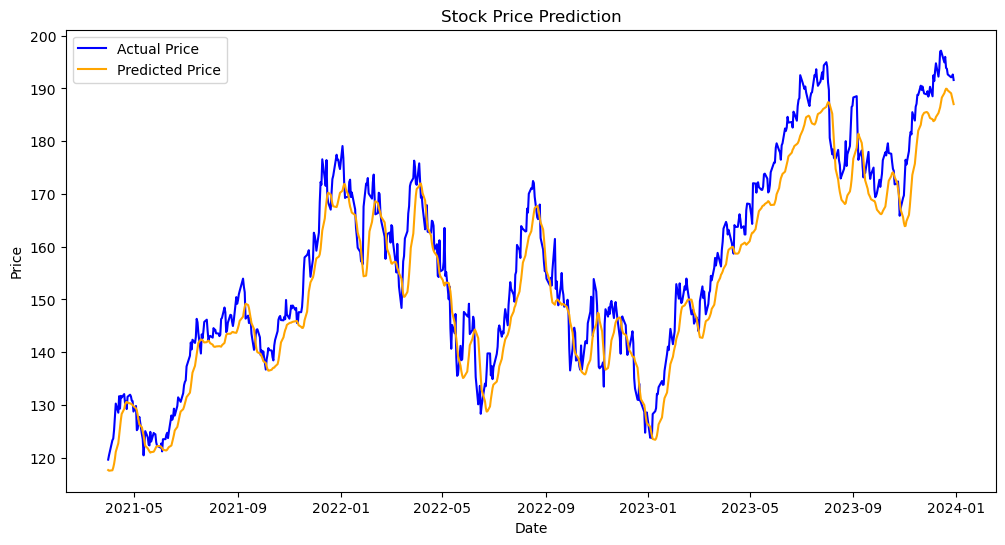

In [10]:
# Plot the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(test_data_dates, actual_prices, color='blue', label='Actual Price')
plt.plot(test_data_dates, predicted_prices, color='orange', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [11]:
from sklearn.model_selection import ParameterGrid

# Define parameter grid
param_grid = {
    'units': [50, 100],
    'layers': [1, 2],
    'batch_size': [16, 32],
    'epochs': [5, 10]
}

# Create grid of parameter combinations
grid = list(ParameterGrid(param_grid))

best_model = None
best_loss = float('inf')

# Iterate through all combinations
for params in grid:
    model = Sequential()
    model.add(LSTM(units=params['units'], return_sequences=params['layers'] > 1, 
                   input_shape=(X_train.shape[1], 1)))
    if params['layers'] == 2:
        model.add(LSTM(units=params['units']))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train model
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
    
    # Evaluate model
    loss = model.evaluate(X_test, y_test, verbose=0)
    if loss < best_loss:
        best_loss = loss
        best_model = model
        best_params = params

print("Best Parameters:", best_params)


/home/akkey/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best Parameters: {'batch_size': 16, 'epochs': 10, 'layers': 1, 'units': 50}


In [12]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print("Root Mean Squared Error (RMSE):", rmse)



Root Mean Squared Error (RMSE): 5.655759884833462


In [13]:
from sklearn.metrics import r2_score

r2 = r2_score(actual_prices, predicted_prices)
print("R-Squared (R²):", r2)


R-Squared (R²): 0.9117780445004278


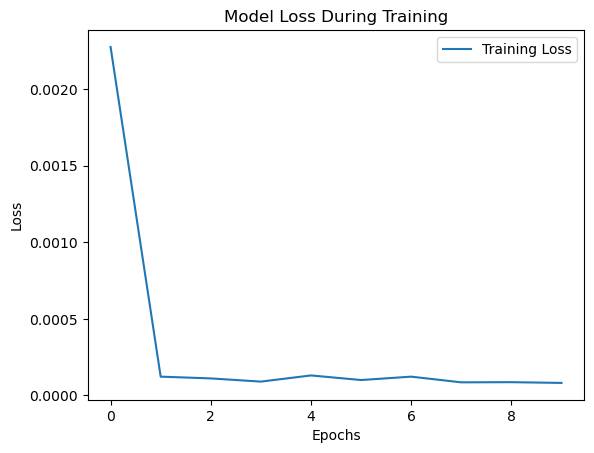

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
best_model.save('best_stock_prediction_model.h5')


In [16]:
from tensorflow.keras.models import load_model

loaded_model = load_model('best_stock_prediction_model.h5')
predicted_prices = loaded_model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


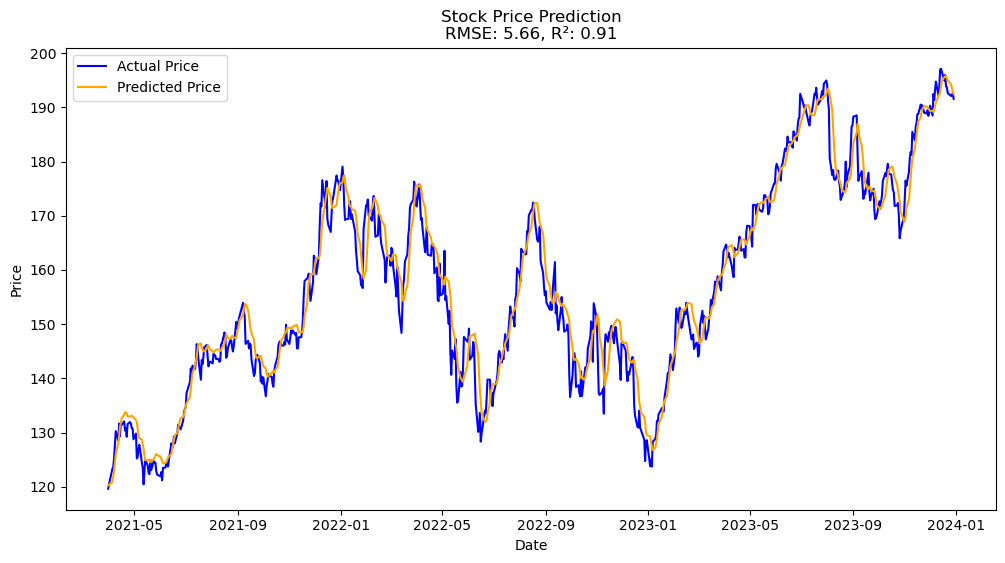

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(test_data_dates, actual_prices, color='blue', label='Actual Price')
plt.plot(test_data_dates, predicted_prices, color='orange', label='Predicted Price')
plt.title(f'Stock Price Prediction\nRMSE: {rmse:.2f}, R²: {r2:.2f}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
